# 0. Tools & Imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

sns.set_style("darkgrid")

# 1. Datasets

In [2]:
dataset_url = "./data/online_shoppers_intention.csv"
dataset = pd.read_csv(dataset_url)

FileNotFoundError: [Errno 2] No such file or directory: './data/online_shoppers_intention.csv'

# 2. Brief EDA

In [ ]:
dataset.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [ ]:
duplicate_rows_df = dataset[dataset.duplicated()]
print("The number of duplicate rows: ", duplicate_rows_df.shape)
print("We will use duplicate_rows_df later to remove duplicated rows")

The number of duplicate rows:  (125, 18)
We will use duplicate_rows_df later to remove duplicated rows


<AxesSubplot:>

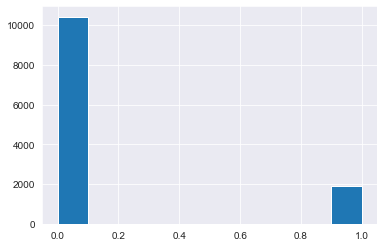

In [ ]:
# Separating Numerical Cols
numerical_cols = dataset.columns[:10]
categorical_cols = dataset.columns[10:]

dataset["Revenue"].astype(int).hist()

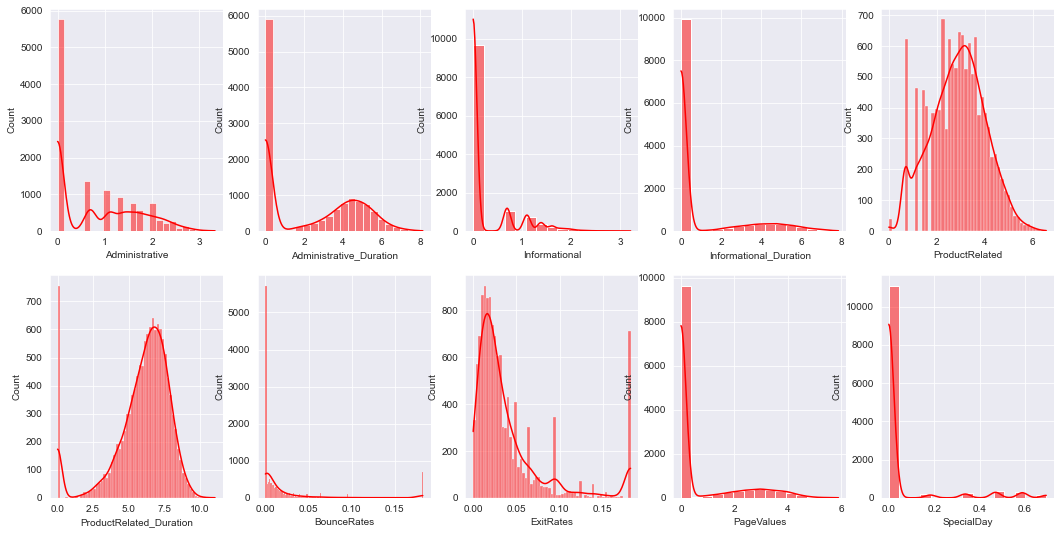

In [ ]:
# Log1p transformation to reduce skewnesss (Known from Previous EDA)
for col in numerical_cols:
    dataset[col] = np.log1p(dataset[col]) 

fig, axes = plt.subplots(2, 5, figsize=(18, 9))
axes =  axes.flatten()
for i, c in enumerate(numerical_cols): 
	sns.histplot(dataset, ax=axes[i], x=numerical_cols[i], kde=True,  color='r', stat='count')

# 3. Data Cleaning & Transformation

In [ ]:
# Converting Categorial Features that contains strings to numbers
dataset['VisitorType'] = dataset['VisitorType'].astype('category').cat.codes
dataset['Weekend'] = dataset['Weekend'].astype('category').cat.codes
dataset['Revenue'] = dataset['Revenue'].astype('category').cat.codes
dataset['Month'] = dataset['Month'].astype('category').cat.codes

dataset.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,0.693147,0.000000,0.182322,0.182322,0.0,0.0,2,1,1,1,1,2,0,0
1,0.0,0.0,0.0,0.0,1.098612,4.174387,0.000000,0.095310,0.0,0.0,2,2,2,1,2,2,0,0
2,0.0,0.0,0.0,0.0,0.693147,0.000000,0.182322,0.182322,0.0,0.0,2,4,1,9,3,2,0,0
3,0.0,0.0,0.0,0.0,1.098612,1.299283,0.048790,0.131028,0.0,0.0,2,3,2,2,4,2,0,0
4,0.0,0.0,0.0,0.0,2.397895,6.443336,0.019803,0.048790,0.0,0.0,2,3,3,1,4,2,1,0


# 4. Naive Bayes Implementation
## 4.1 Naive Bayes 
 

In [ ]:
def calculate_prior(df, Y):
	classes = sorted(list(df[Y].unique()))
	prior = []
	for i in classes:
		prior.append(len(df[df[Y]==i])/len(df))
	return prior

def calculate_likelihood_categorical(df, feat_name, feat_value, Y, label):
	
	# total number of Y labels
	df = df[df[Y] == label]

	p_x_given_ylabel = len(df[df[feat_name]== feat_value])/len(df)
	return p_x_given_ylabel


def naive_bayes_categorical(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)

## 4.2. Test Model

-  We are going to split the model into Training and testing



In [ ]:
##  Naive Bayes Categorial
naive_bayes_df = dataset.copy()
# Converting continious features to discrete variables
for i, col in enumerate(numerical_cols):
	new_col_name = 'cat_'+ col
	naive_bayes_df[new_col_name] = pd.cut(naive_bayes_df[col].values, bins = 5, labels = [0,1,2,3,4])

cat_df = naive_bayes_df.drop(columns=numerical_cols, axis=1)

In [ ]:
def train_test_data_resampling(data):
	train, test = train_test_split(data, test_size=.3, random_state=41)
	smote = SMOTE(random_state=42, sampling_strategy='minority')


	X_train = train[train.columns.drop(['Revenue'])]
	y_train = train['Revenue']

	# SMOTE resampling
	X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

	train = pd.concat([pd.DataFrame(X_train_resampled, columns=X_train_resampled.columns),
							pd.Series(y_train_resampled, name='Revenue')],
							axis=1)
	
	return train, test

In [ ]:

train, test = train_test_data_resampling(cat_df)
X_test = test[cat_df.columns.drop(['Revenue'])].values
Y_test = test['Revenue'].values


In [ ]:
# Naive Bayes Implementation
Y_pred = naive_bayes_categorical(train, X=X_test, Y='Revenue')

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("The model's accuracy score: ", accuracy_score(Y_test, Y_pred))
print("The confusoin Matrix: ",confusion_matrix(Y_test, Y_pred))
print("The Precision Score: ", precision_score(Y_test, Y_pred))
print("The Recall Score: ", recall_score(Y_test, Y_pred))
print("The F1 score",f1_score(Y_test, Y_pred))


The model's accuracy score:  0.8572587185725872
The confusoin Matrix:  [[2740  383]
 [ 145  431]]
The Precision Score:  0.5294840294840295
The Recall Score:  0.7482638888888888
The F1 score 0.6201438848920864


**Previous model's accuracy score:** 
- 0.7266828872668288 <br>
- The confusoin Matrix: <br>
 [[1701  397]<br>
 [ 277   91]]<br>
- The F1 score 0.21261682242990654<br>

**New Model**: 
- The model's accuracy score:  0.7400648824006488
- The confusoin Matrix: <br>
 [[1523  575] <br>
 [  66  302]]<br>
- The F1 score 0.485140562248996  <br>

Results: By doing SMOTE Data Resamling our F1 score more than doubled. 

# 5. Logistical Regression Implementation
## 5.1 Logistical Regression

In [ ]:
from numpy import log, dot, e
from numpy.random import rand

class LogisticRegression:
    
    def sigmoid(self, z): return 1 / (1 + e**(-z))
    
    def cost_function(self, X, y, weights):                 
        z = dot(X, weights)        
        predict_1 = y * log(self.sigmoid(z))
        predict_0 = (1 - y) * log(1 - self.sigmoid(z))        
        return -sum(predict_1 + predict_0) / len(X)
    
    def fit(self, X, y, epochs=25, lr=0.05):        
        loss = []
        weights = rand(X.shape[1])
        N = len(X)
                 
        for _ in range(epochs):        
            # Gradient Descent
            y_hat = self.sigmoid(dot(X, weights))
            weights -= lr * dot(X.T,  y_hat - y) / N            
            # Saving Progress
            cost = self.cost_function(X, y, weights)
            loss.append(cost) 
            
            if _ % 20 == 0:
                print(f"Epoch {_}, Loss: {cost:.4f}")
            
        self.weights = weights
        self.loss = loss

        
    
    def predict(self, X):        
        # Predicting with sigmoid function
        z = dot(X, self.weights)
        # Returning binary result
        return [1 if i > 0.5 else 0 for i in self.sigmoid(z)]

## 5.2 Test the Logistical Model

In [ ]:
from sklearn.preprocessing import OneHotEncoder



def one_hot_encode_dataset(dataset, categorical_cols):
	# Extract categorical data
	categorical_data = dataset[categorical_cols]

	# Create and fit encoder (using defaults)
	encoder = OneHotEncoder(drop='first')  # no sparse_output or handle_unknown
	encoded_array = encoder.fit_transform(categorical_data).toarray()  # convert sparse matrix to dense

	# Get new column names
	encoded_col_names = encoder.get_feature_names_out(categorical_cols)

	# Create DataFrame of encoded features
	encoded_df = pd.DataFrame(encoded_array, columns=encoded_col_names, index=dataset.index)

	# Drop original categorical columns and join encoded features
	dataset.drop(columns=categorical_cols, inplace=True)
	dataset = pd.concat([dataset, encoded_df], axis=1)

	# Rename the column
	dataset.rename(columns={'Revenue_1': 'Revenue'}, inplace=True)

	return dataset

logistical_dataset = dataset.copy()


In [ ]:

train, test = train_test_data_resampling(logistical_dataset)

X_train = train[logistical_dataset.columns.drop(['Revenue'])].values
y_train = train['Revenue'].values

X_test = test[logistical_dataset.columns.drop(['Revenue'])].values
y_test = test['Revenue'].values

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train, epochs=500, lr=0.1)
y_pred = logreg.predict(X_test)

Epoch 0, Loss: 4.1226
Epoch 20, Loss: 0.4590
Epoch 40, Loss: 0.4104
Epoch 60, Loss: 0.3968
Epoch 80, Loss: 0.3895
Epoch 100, Loss: 0.3846
Epoch 120, Loss: 0.3810
Epoch 140, Loss: 0.3783
Epoch 160, Loss: 0.3762
Epoch 180, Loss: 0.3746
Epoch 200, Loss: 0.3733
Epoch 220, Loss: 0.3722
Epoch 240, Loss: 0.3714
Epoch 260, Loss: 0.3707
Epoch 280, Loss: 0.3701
Epoch 300, Loss: 0.3696
Epoch 320, Loss: 0.3691
Epoch 340, Loss: 0.3688
Epoch 360, Loss: 0.3684
Epoch 380, Loss: 0.3681
Epoch 400, Loss: 0.3679
Epoch 420, Loss: 0.3676
Epoch 440, Loss: 0.3674
Epoch 460, Loss: 0.3672
Epoch 480, Loss: 0.3670


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("Results: \n\n  The model's accuracy score: ", accuracy_score(y_test, y_pred))
print("  The confusoin Matrix: \n",confusion_matrix(y_test, y_pred))
print("  The Precision Score: ", precision_score(y_test, y_pred))
print("  The Recall Score: ", recall_score(y_test, y_pred))
print("  The F1 score",f1_score(y_test, y_pred))


Results: 

  The model's accuracy score:  0.8580697485806975
  The confusoin Matrix: 
 [[2744  379]
 [ 146  430]]
  The Precision Score:  0.5315203955500618
  The Recall Score:  0.7465277777777778
  The F1 score 0.6209386281588447



We can see that using a logistical Regression we can improve our model performance and F1 score <br>

We will now plot the loss over the epoch.

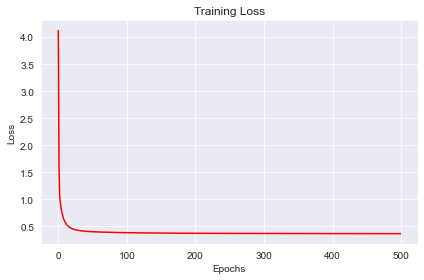

In [ ]:
# Training Loss
training_loss = logreg.loss
plt.plot(training_loss, color='red')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

# 6. Nueral Network Implementations

## Model Architecture

- We are going to have 17 input layer for each of our feature variables
- We are also going to have 5 hidden layer
- Lastly 1 output layer for our output variables

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


class NueralNetwork:
	def __init__(self, input_size, hidden_size, output_size, activation='sigmoid'):

		self.input_layer = input_size
		self.hidden_layer = hidden_size
		self.output_layer = output_size
    	
		if activation == 'sigmoid':
			self.activation = self.sigmoid
		else:
			raise ValueError("Activation function is currently not support, please use 'relu' or 'sigmoid' instead.")

		self.params =  self.initialize()

	# Activiaation function
	def sigmoid(self, x, derivative=False):
		if derivative:
			return (np.exp(-x))/((np.exp(-x)+1)**2)
		return(1/(1 + np.exp(-x)))
	
	def initialize(self):
		params = {
            "W1": np.random.randn(self.hidden_layer, self.input_layer) * np.sqrt(1./self.input_layer),
            "b1": np.zeros((self.hidden_layer, 1)) * np.sqrt(1./self.input_layer),
            "W2": np.random.randn(self.output_layer, self.hidden_layer) * np.sqrt(1./self.hidden_layer),
            "b2": np.zeros((self.output_layer, 1)) * np.sqrt(1./self.hidden_layer)
        }
		return params
	
	# input Y true, and predicted y_hat between 0 and 1
	def compute_loss(self, y, y_hat):		
		L = -np.multiply(y, np.log(y_hat)) - np.multiply(1-y, np.log(1-y_hat))

		return np.mean(L)

	def f_forward(self, x):

		z1 = np.dot(x, self.params['W1'].T)  + self.params["b1"].T
		a1 = self.activation(z1)

		z2 = np.dot(a1, self.params['W2'].T) + self.params["b2"]
		a2 = self.activation(z2)
		
		return [z1,a1, z2, a2]
	
	def back_propagate(self, x, y, output, alpha):
		
		a1 = output[1]
		a2 = output[3]

		w1 = self.params["W1"]
		w2 = self.params['W2']

		current_batch_size = y.shape[0]
		
		# error in output layer
		y = y.reshape(-1, 1)
		d2 =a2-y
	
		d1 = np.multiply(np.dot(d2, w2), np.multiply(a1, 1-a1))
		w1_adj = (1./current_batch_size)*np.dot(d1.T , x)
		w2_adj = (1./current_batch_size)*np.dot(d2.T, a1)
		
		b1_adj = (1/current_batch_size)*np.sum(d1, axis=0, keepdims=True).T  # shape: (5, 1)
		b2_adj = (1/current_batch_size)*np.sum(d2, axis=0, keepdims=True).T

		# Updating parameters
		self.params["W1"] = w1-(alpha*(w1_adj))
		self.params['W2'] = w2-(alpha*(w2_adj))

		# # Bias updates (gradient descent)
		self.params["b1"] = self.params["b1"] - (alpha * b1_adj)
		self.params["b2"] = self.params["b2"] - (alpha * b2_adj)
				

	def train_model(self,X_train, Y_train, X_test, Y_test, epoch=10, alpha=0.01, batch_size=64):
		train_acc = []
		train_loss = []

		test_acc, test_loss = [],[]

		num_batches = -(-X_train.shape[0] // batch_size)

		for i in range(epoch):
			permutation = np.random.permutation(X_train.shape[0])
			x_train_shuffled = X_train[permutation]
			y_train_shuffled = Y_train[permutation]

			for j in range(num_batches):
				begin = j * batch_size
				end = min(begin + batch_size, X_train.shape[0]-1)
				x = x_train_shuffled[begin:end]
				y = y_train_shuffled[begin:end]

				output = self.f_forward(x)

				self.back_propagate(x, y, output, alpha)

			
			###  ========================== TESTING PORTION =================== ###
			# Training Test
			acc, _, _, _, loss = self.test_model(x_train_shuffled, y_train_shuffled)
			train_acc.append(acc)
			train_loss.append(loss)

			# Testing Test
			acc2, _, _, _, loss2 = self.test_model(X_test, Y_test)
			test_acc.append(acc2)
			test_loss.append(loss2)
			print(f"Epoch {i + 1:>2} | Train Acc: {acc:.4f} | Train Loss: {loss:.4f} || Test Acc: {acc2:.4f} | Test Loss: {loss2:.4f}")
			###  ========================== TESTING PORTION ENDS =================== ###
		
		return train_acc, train_loss, test_acc, test_loss

	# Input X ndarray --- output
	def predict(self, X):
		output = self.f_forward(X)
		
		labels = (output[3] >= 0.5).astype(int)
		y_pred =  labels.flatten()
		return y_pred

	def test_model(self, X, Y):
		output = self.f_forward(X)

		y_true = Y.flatten()
		y_pred = output[3].flatten()

		# Loss calculated using binary entopy 
		loss = self.compute_loss(y_true, y_pred)

		# Finding the labels
		labels = (output[3] >= 0.5).astype(int)
		y_pred = labels.flatten()

		# Calculate Accuracy, precisioin, recall, and F1
		accuracy = accuracy_score(y_true, y_pred)
		precision = precision_score(y_true, y_pred, zero_division=1)
		recall = recall_score(y_true, y_pred)
		f1 = f1_score(y_true, y_pred)

		return accuracy, precision, recall, f1, loss

				

In [ ]:
train, test  = train_test_data_resampling(dataset)
X_train, y_train  = train[train.columns.drop(['Revenue'])].values, train['Revenue'].values
X_test, y_test  = train[train.columns.drop(['Revenue'])].values, train['Revenue'].values

nn = NueralNetwork(17, 5, 1)
train_acc , train_loss, test_acc, test_loss = nn.train_model(X_train, y_train, X_test, y_test, epoch=500, alpha=0.0005)

Epoch  1 | Train Acc: 0.4944 | Train Loss: 0.6909 || Test Acc: 0.4944 | Test Loss: 0.6909
Epoch  2 | Train Acc: 0.5179 | Train Loss: 0.6865 || Test Acc: 0.5179 | Test Loss: 0.6865
Epoch  3 | Train Acc: 0.5355 | Train Loss: 0.6824 || Test Acc: 0.5355 | Test Loss: 0.6824
Epoch  4 | Train Acc: 0.5562 | Train Loss: 0.6787 || Test Acc: 0.5562 | Test Loss: 0.6787
Epoch  5 | Train Acc: 0.5773 | Train Loss: 0.6752 || Test Acc: 0.5773 | Test Loss: 0.6752
Epoch  6 | Train Acc: 0.5992 | Train Loss: 0.6720 || Test Acc: 0.5992 | Test Loss: 0.6720
Epoch  7 | Train Acc: 0.6239 | Train Loss: 0.6688 || Test Acc: 0.6239 | Test Loss: 0.6688
Epoch  8 | Train Acc: 0.6452 | Train Loss: 0.6658 || Test Acc: 0.6452 | Test Loss: 0.6658
Epoch  9 | Train Acc: 0.6682 | Train Loss: 0.6628 || Test Acc: 0.6682 | Test Loss: 0.6628
Epoch 10 | Train Acc: 0.6865 | Train Loss: 0.6599 || Test Acc: 0.6865 | Test Loss: 0.6599
Epoch 11 | Train Acc: 0.7008 | Train Loss: 0.6570 || Test Acc: 0.7008 | Test Loss: 0.6570
Epoch 12 |

# 6.2 Test Nueral Network Model

In [ ]:
accuracy, precision, recall, f1, _ = nn.test_model(X_test, y_test)

y_pred = nn.predict(X_test)

# Print results
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

Accuracy:  0.8577
Precision: 0.8812
Recall:    0.8270
F1 Score:  0.8532
Confusion Matrix: 
 [[6485  814]
 [1263 6036]]


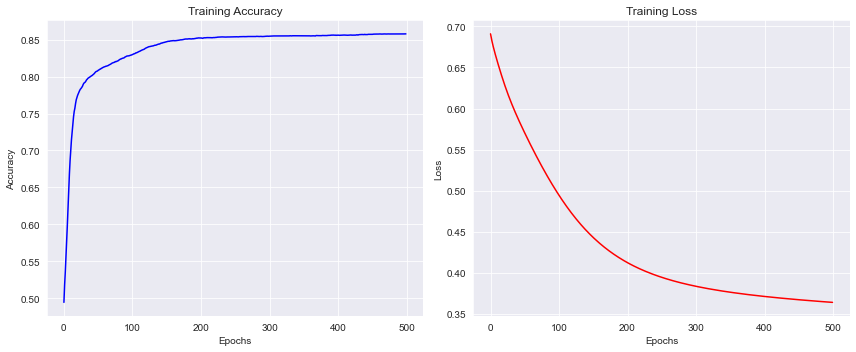

In [ ]:
import matplotlib.pyplot as plt1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Training Accuracy plot
ax1.plot(train_acc, color='blue')
ax1.set_title('Training Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

# Training Loss plot
ax2.plot(train_loss, color='red')
ax2.set_title('Training Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

plt.tight_layout()
plt.show()

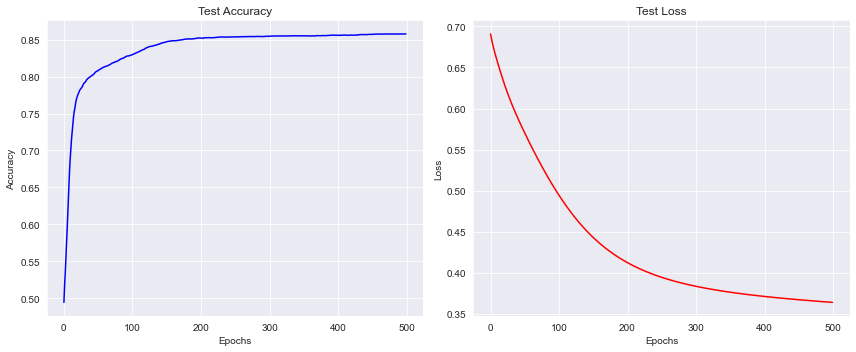

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Training Accuracy plot
ax1.plot(test_acc, color='blue')
ax1.set_title('Test Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

# Testing Loss plot
ax2.plot(test_loss, color='red')
ax2.set_title('Test Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

plt.tight_layout()
plt.show()